# Lab 5

## Business Understanding

Humanity's exploration to the outer space has never stopped or slowed. We look into the sky at night and wonder what and who could be out there. We searched the universe using the best technology humanity have access to and we made great progress. 
![Tesla in Space](tesla.jpg)
With the progress made on machine learning and AI, it would only make sense to apply the tools and applications from ML/AI to universe explorations. 
The dataset we chose is a set of observations of the sky taken by SDSS (Sloan Digital Sky Survey). It contains 10,000 instances of observations with each 17 features. Each observation belongs to one of these three classes: Galaxy, Star and Quasar. 
![Qasar](qasar.jpg)
In this project we want to build classification models that can successfully tell which object is in the observation. With the classification model in place, automatic recording system can be established to observe the sky and find new stars or galaxies, classify them and put into database for future research or data-mining. 

## 1.1 Dataset Overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
df = pd.read_csv('./Skyserver_SQL2_27_2018 6_51_39 PM.csv', delimiter=',', header=1)
df.head()

objid          ra       dec         u         g         r  \
0  1237648704577142822  183.531326  0.089693  19.47406  17.04240  15.94699   
1  1237648704577142859  183.598371  0.135285  18.66280  17.21449  16.67637   
2  1237648704577208477  183.680207  0.126185  19.38298  18.19169  17.47428   
3  1237648704577273907  183.870529  0.049911  17.76536  16.60272  16.16116   
4  1237648704577273909  183.883288  0.102557  17.55025  16.26342  16.43869   

          i         z  run  rerun  camcol  field            specobjid   class  \
0  15.50342  15.22531  752    301       4    267  3722360139651588096    STAR   
1  16.48922  16.39150  752    301       4    267   363814405953054720    STAR   
2  17.08732  16.80125  752    301       4    268   323274319570429952  GALAXY   
3  15.98233  15.90438  752    301       4    269  3722365362331820032    STAR   
4  16.55492  16.61326  752    301       4    269  3722365912087633920    STAR   

   redshift  plate    mjd  fiberid  
0 -0.000009   3306  54922      491  
1 -0.000055    323  51615      541  
2  0.123111    287  52023      513  
3 -0.000111   3306  54922      510  
4  0.000590   3306  54922      512

First we read in the csv file and put it into a Pandas dataframe. After study the colums of the data set, we found that some of them are actually irrelevant to the classification task, like 'object id', 'run'. These are just system generated identification numbers and have nothing to do with the observation itself, so we will drop these columns from our dataframe. 

In [3]:
#drop columns that are not features impacting classifications
df.drop(['objid', 'specobjid', 'run', 'rerun', 'camcol', 'plate', 'mjd', 'fiberid', 'field'], axis=1, inplace=True)

### 1.2 Cross-product Features
Next, we want to find out whether there are features that are closely related to each other. If so, we can do some demensional reduction to further 'distill' the data for faster computation. 

In [4]:
df.describe()

ra           dec             u             g             r  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean     175.529987     14.836148     18.619355     17.371931     16.840963   
std       47.783439     25.212207      0.828656      0.945457      1.067764   
min        8.235100     -5.382632     12.988970     12.799550     12.431600   
25%      157.370946     -0.539035     18.178035     16.815100     16.173333   
50%      180.394514      0.404166     18.853095     17.495135     16.858770   
75%      201.547279     35.649397     19.259232     18.010145     17.512675   
max      260.884382     68.542265     19.599900     19.918970     24.802040   

                  i             z      redshift  
count  10000.000000  10000.000000  10000.000000  
mean      16.583579     16.422833      0.143726  
std        1.141805      1.203188      0.388774  
min       11.947210     11.610410     -0.004136  
25%       15.853705     15.618285      0.000081  
50%       16.554985     16.389945      0.042591  
75%       17.258550     17.141447      0.092579  
max       28.179630     22.833060      5.353854

Prepare Class variables
Identify features that should be combined into cross product feature . Why ? Provice justification.

In [5]:
df.corr()

ra       dec         u         g         r         i  \
ra        1.000000  0.003596  0.031238  0.043909  0.047103  0.045731   
dec       0.003596  1.000000  0.035279  0.061875  0.063404  0.058292   
u         0.031238  0.035279  1.000000  0.849232  0.692379  0.602630   
g         0.043909  0.061875  0.849232  1.000000  0.958106  0.907419   
r         0.047103  0.063404  0.692379  0.958106  1.000000  0.977672   
i         0.045731  0.058292  0.602630  0.907419  0.977672  1.000000   
z         0.042950  0.056870  0.551483  0.879622  0.969197  0.981507   
redshift  0.030307  0.067021  0.163741  0.407576  0.441080  0.431450   

                 z  redshift  
ra        0.042950  0.030307  
dec       0.056870  0.067021  
u         0.551483  0.163741  
g         0.879622  0.407576  
r         0.969197  0.441080  
i         0.981507  0.431450  
z         1.000000  0.424034  
redshift  0.424034  1.000000

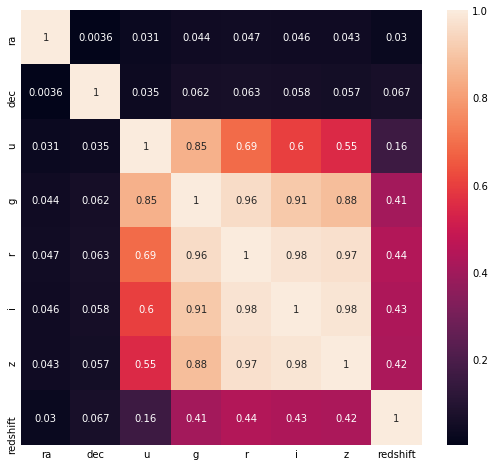

In [6]:
f, ax = plt.subplots(1, figsize=(8,8))
sns.heatmap(df.corr(), annot=True, ax=ax)

After doing some covariance matrix and heat map of all the features, we observed that 'g', 'r', 'i', 'z' are tightly corelated to each other, with 'u' very close to them. We'll perform some PCA and reduce the demension. 

In [7]:
#since g, r, i, z are highly correlate to each other, it makes sense to do PCA on these 4.
pca_val = df[['g', 'r', 'i', 'z']]
pca = PCA(n_components=1)
pca_val = pca.fit_transform(pca_val)
print(pca_val.shape)
pca_val = pca_val.reshape(-1,)

(10000, 1)


In [8]:
pca_val = pd.Series(pca_val, name='pca_val')
df = pd.concat([df, pca_val], axis=1)
df.drop(['g', 'r', 'i', 'z'], axis=1, inplace=True)
df.head()

ra       dec         u   class  redshift   pca_val
0  183.531326  0.089693  19.47406    STAR -0.000009 -1.809151
1  183.598371  0.135285  18.66280    STAR -0.000055 -0.214012
2  183.680207  0.126185  19.38298  GALAXY  0.123111  1.128840
3  183.870529  0.049911  17.76536    STAR -0.000111 -1.259402
4  183.883288  0.102557  17.55025    STAR  0.000590 -0.570706

In [9]:
# prepare data for ML
X = df.drop('class', axis=1)
y = df['class']
y.value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

In [10]:
le = LabelEncoder()
y = le.fit_transform(y)

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# TODO (Lin): 
- Identify groups of features in your data that should be combined into cross-product features. Provide justification for why these features should be crossed (or why some features should not be crossed).

## 1.3 Evaluation

 # TODO (Mrunal and Dhwani) [10 points] : 
- Choose and explain what metric(s) you will use to evaluate your *algorithmâ€™s performance*. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

For our dataset, we are performing a multi-class classification where each class has equal importance as it would be difficult to argue whether finding a new galaxy is more important than finding a new star or quasar. Hence, there are not much difference between False Negatives(FN)and False Positives(FP). Therefore, in our case, accuracy will be good for evaluation criteria.

To explore the idea, we made a Cost Matrix like below:

| Cost	| Predict No 	| Predict Yes	|
|----	|----	|----	|
| Actual No 	| -1 	| 1 	|
| Actual Yes 	| 1 	| -10 	|


As we can see from the above matrix,we have explained it for Star but can be considered the smae for Galaxy or Quasar as well similarly: 
If the object is not Star and we predict it correctly to be not Star, it will be beneficial for us by reducing the cost, so we give it -1 cost .
If the object is Star and we predict it as Star, then it help us, actually reducing the cost, so we give it a -10 cost.
For the case of False Positives and False Negatives, it's not good for us but maybe OK. We will send it to expert to manually clasify it, thus adding some but not very much cost. We give it a cost of 1 as the loss suffered will only be monetory i.e. usage of resouces in exploring and detecting the space objects.


## 1.4 Train/Test Data Split





# TODO (Mrunal and Dhwani) [10 points]: 
- Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?).
- Explain why your chosen method is appropriate or use more than one method as appropriate.
- Convince that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

For cross validation of our dataset, a holdout which split the training set and testing set with 80/20 could work. But if using holdout, we miss 20% of the testing data that never used for training and there is no cross validation. K-fold cross validation is better, but K-fold will treat all class equally without looking at classes distribution. The best way is to use Stratified K-fold where we use all the data for cross validation and it's sensitive to classes distribution (size of each class). So this is the cross-validation method we'll use. (Our dataset used is equally spreaded across classes, but that's because we manually picked it, in actuality, the data set is not likely to be evenly spreaded, so Stratified K-fold is better). We also tried ShuffleSplit in the code in-case we want some comparison later. 

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression

In [12]:
#Splitting data using Shuffle Split
s_split = ShuffleSplit(n_splits=5, test_size=0.2)
for train_index, test_index in s_split.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8000, 5)
(8000,)
(2000, 5)
(2000,)


Accuracy 0.776998104748 [ 0.76404494  0.77902622  0.79650437  0.80774032  0.74157303  0.78125     0.78
  0.76595745  0.79072682  0.76315789]
CPU times: user 244 ms, sys: 8.4 ms, total: 252 ms
Wall time: 263 ms


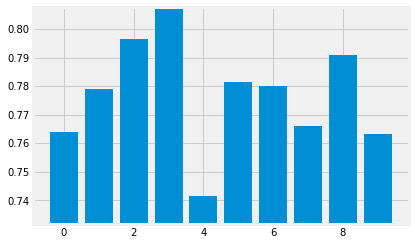

In [13]:
%%time
# select model
clf = LogisticRegression()
#select cross validation
cv = StratifiedKFold(n_splits=10, shuffle=False, random_state=None).split(X_train, y_train)
# select evaluation criteria
#my_scorer = make_scorer(recall_score)
# run model training and cross validation
#my_scorer = make_scorer(precision_score,average='macro')

per_fold_eval_criteria = cross_val_score(estimator=clf,
                                    X=X_train,
                                    y=y_train,
                                    cv=cv,#integer, to specify the number of folds in a (Stratified)KFold
                                    scoring='accuracy')


print('Accuracy', np.mean(per_fold_eval_criteria), per_fold_eval_criteria)

plt.bar(range(len(per_fold_eval_criteria)),per_fold_eval_criteria)
plt.ylim([min(per_fold_eval_criteria)-0.01,max(per_fold_eval_criteria)])

We experimented with different methods for dividing our data into training and testing.

With train/test split, high variance estimate was observed as the testing accuracy significantly depends on which observations happen to be in the testing set. This dependency and high variance were not a good points to go ahead with train/test split for our data.

With StratifiedKFold cross validation method,we are able to achieve more accurate estimate of out-of-sample accuracy. Also,it turns to be a more efficient use of data as every observation is used for both training and testing.

Hence, we are using Stratified 10 Fold cross validation method as it balances the folds as is less impacted by biases by over- or under-representation of classes as it uses balancing technique. It helps us detect over-fitting by letting us know when our fitting approach isn't generalizing to new data.

# Modelling

### Wide and deep networks to classify using Keras

In [14]:
from sklearn import metrics as mt
from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.layers import Embedding, Flatten, Merge, concatenate
from keras.models import Model

#pip install tensorflow ; pip install keras;

Using TensorFlow backend.


In [15]:
# combine the features into a single large matrix
X_train = df_train[feature_columns].values
X_test = df_test[feature_columns].values

#one hot encoding the categorical features
from sklearn.preprocessing import OneHotEncoder

# now let's encode the integer outputs as one hot encoded labels
ohe = OneHotEncoder()
X_train_ohe = ohe.fit_transform(df_train[categorical_headers_ints].values)
X_test_ohe = ohe.transform(df_test[categorical_headers_ints].values)

# the ohe instance will help us to organize our encoded matrix
print(ohe.feature_indices_)
print(X_train_ohe.shape)
print(type(X_train_ohe), '========SPARSE ENCODED=======')

NameError: name 'df_train' is not defined

In [ ]:
# This returns a tensor
# the input can only be a scipy.sparse array
inputs = Input(shape=(X_train_ohe.shape[1],), sparse=True)

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(units=10, activation='relu')(inputs)
predictions = Dense(1,activation='sigmoid')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit(X_train_ohe,y_train, epochs=10, batch_size=50, verbose=0)

# test on the data
yhat = np.round(model.predict(X_test_ohe))
print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))

# TODO

- Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations. Try to use the "history" return parameter that is part of Keras "fit" function.
- Investigate generalization performance by altering the number of layers in the deep branch of the network. Try at least two different number of layers. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab.
- Cross validation and evaluation
    - Try Different cross product.
    - Statistical model - T Test? 
    - Visualize performance.

### Comparing Performance with a Standard Multi-layer Perceptron.

In [ ]:
from sklearn import __version__ as sklearn_version
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

print(sklearn_version)
# these values have been hand tuned
clf = MLPClassifier(hidden_layer_sizes=(50, ), 
                    activation='logistic', 
                    solver='sgd', 
                    alpha=1e-4, # L2 penalty
                    batch_size='auto', # min of 200, num_samples
                    learning_rate='constant', 
                    learning_rate_init=0.1, # only SGD
                    power_t=0.5,    # only SGD
                    max_iter=75, 
                    shuffle=True, 
                    random_state=1, 
                    tol=1e-9, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=True, # only SGD
                    early_stopping=False, 
                    validation_fraction=0.1, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer

%time clf.fit(X_train,y_train)
yhat = clf.predict(X_test)
print('Validation Acc:',accuracy_score(yhat,y_test))

#### Receiver operating characteristic ROC & Area under the curve

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_scores)

## Exceptional work
# TODO : 
- Capture the embedding wights from the deep network and perform T SNE Clustering of the output of these embedding layers.
- USE THE GET WEIGHT FUNCTION.
- Why Cluster? 
- Choose 2 categories which would interesting to look.
